In [3]:
import pandas as pd               # Pandas handles dataframes
import numpy as np
import scipy
import matplotlib                 # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
import statsmodels

In [4]:
# create a data for scatterplot simulation
np.random.seed(666)
x_value = np.random.randint(-20,100,size=80)
y_value = np.square(x_value)/2 + np.random.randint(-200, 1000, size=80)
# add outliers
outlier_index = [np.random.randint(0, 79, size=20)]
y_value[outlier_index] = y_value[outlier_index]*2
df = pd.DataFrame({"X":x_value, "Y":y_value})
df.head(10)

,X,Y
0,88,4759.0
1,-18,1137.0
2,25,731.5
3,10,757.0
4,42,3008.0
5,50,3986.0
6,53,3783.0
7,10,639.0
8,16,789.0
9,41,1479.0


Text(0.5,1,'(N = 1000)')

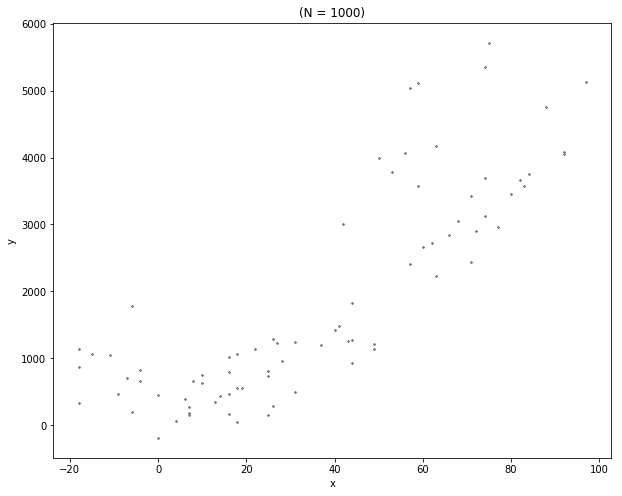

In [5]:
# plot data
plt.rcParams["figure.figsize"] = (10,8)
plt.scatter(df["X"], df["Y"],color="grey",s=3,marker="x")
plt.xlabel("x"), plt.ylabel("y")
plt.title('(N = 1000)')

Text(0.5,1,'Test data - with linear trend line')

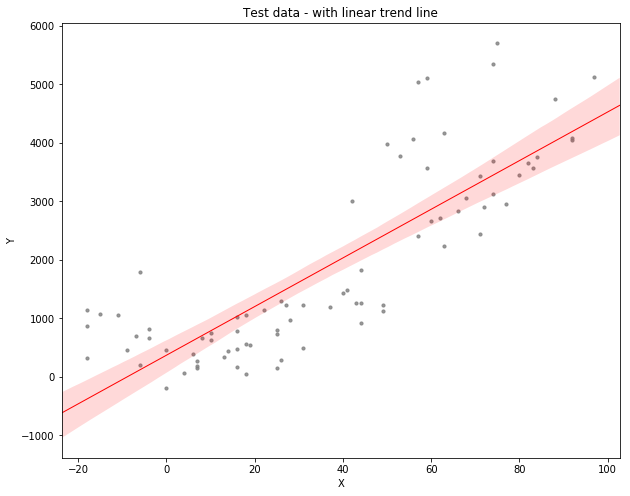

In [6]:
# Create linear trend line
sns.regplot("X", "Y", data=df,  color="grey", scatter_kws={"s": 10},
             line_kws={"color":"r","alpha":1,"lw":1} ,fit_reg=True)
plt.xlabel("X"), plt.ylabel("Y")
plt.title('Test data - with linear trend line')

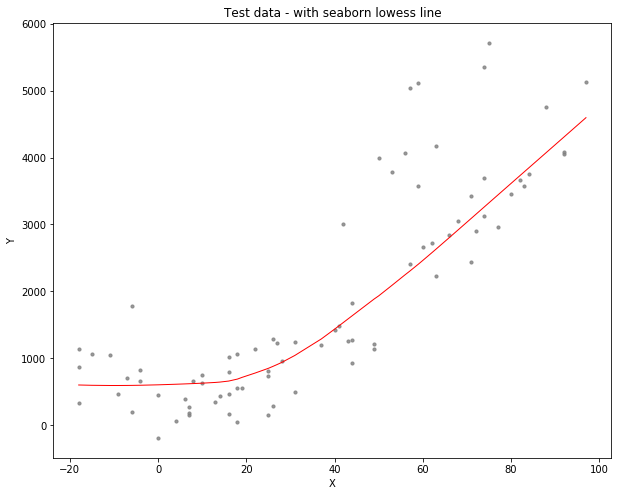

In [7]:
# Seaborne solution:
sns.regplot("X", "Y", data=df,  color="grey", scatter_kws={"s": 10},
             line_kws={"color":"r","alpha":1,"lw":1} ,lowess=True)
plt.xlabel("X"), plt.ylabel("Y")
plt.title('Test data - with seaborn lowess line')
plt.show()

In [8]:
# define lowess and lowess smooth function


# estimate polynomial based on given single x and coefficient
def poly_est_point(x, b):
    est = 0
    for i in enumerate(b): est+=i[1]*(x**i[0])
    return(est)


# estimate polynomial based on a list of x and coefficient
def poly_est_vector(x, b):
    x   = np.array(x)
    est = np.array([0] * len(x))
    for i in enumerate(b): est = i[1]*(x**i[0]) + est
    return(est)

# create a polynomial x matrix 
def x_matrix(xvals, poly_degree):
    # create a list of ones with the same length of xvals for saving precalculated polynomial order
    xcols = [np.ones_like(xvals)]
    # calculate polynomial orders, and append to the xcols
    for j in range(1, (poly_degree + 1)):
        xcols.append([i ** j for i in xvals])
    # transpose vertically stacked lists into horizontally stacked vectors 
    X = np.vstack(xcols).T
    return(X)

# compute lowess estimate weighted only on x distance
def runLOWESS(xvals, yvals, data, alpha, poly_degree=1):
    
    # data preparation
    all_data = sorted(zip(data[xvals].tolist(), data[yvals].tolist()), key=lambda x: x[0])
    xvals, yvals = zip(*all_data) # unpack the zip
    evalDF = pd.DataFrame(columns=['interval','estimate']) # create a new dataframe for saving results
    n = len(xvals)
    m = n + 1
    q = int(np.floor(n * alpha) if alpha <= 1.0 and alpha >0 else n) # calculate number of points within spliding window
    avg_interval = max(xvals)-min(xvals)/n
    v_lb = min(xvals)
    v_ub = max(xvals)
    v = enumerate(np.linspace(start=v_lb, stop=v_ub, num=m), start=1)     # create a numerator that interatively visit a list of evenly spaced vector, and started at the second element
    X = x_matrix(xvals, poly_degree)
                    
    for i in v:
        iterpos = i[0]
        iterval = i[1]
        iterdists = sorted([(j, np.abs(j-iterval)) for j in xvals], key=lambda x: x[1])
        _, raw_dists = zip(*iterdists)
        
        # calculate weights
        # weight function (1 - scaled dist^3)^3
        scale_fact = raw_dists[q-1]         # find the largest distance within a spliding window
        scaled_dists = [(j[0],(j[1]/scale_fact)) for j in iterdists]
        x_weights = [(j[0],((1-j[1]**3)**3 if j[1]<=1 else 0)) for j in scaled_dists]
        _, x_weights    = zip(*sorted(x_weights,     key=lambda x: x[0]))
                    
        # local weighted polynomial regression regression process
        W_x       = np.diag(x_weights) # construct weight matrix
        b         = np.linalg.inv(X.T @ W_x @ X) @ (X.T @ W_x @ yvals) # solve regression
        local_est = poly_est_point(iterval, b) # create estimation
        iterDF    = pd.DataFrame({
                       'interval'  :[iterval],
                       'estimate'  :[local_est]
                       })
        evalDF    = pd.concat([evalDF, iterDF]) # append dataframe into empty dataframe for saving result
    evalDF = evalDF[['interval','estimate']]
    return(evalDF)



# compute lowess smooth weighted on both x and y
def runSmoothLOWESS(xvals, yvals, data, alpha, poly_degree=1):
    
    all_data = sorted(zip(data[xvals].tolist(), data[yvals].tolist()), key=lambda x: x[0])
    xvals, yvals = zip(*all_data)
    evalDF = pd.DataFrame(columns=['interval','estimate'])
    n = len(xvals)
    m = n + 1
    q = int(np.floor(n * alpha) if alpha <= 1.0 and alpha >0 else n)
    avg_interval = max(xvals)-min(xvals)/n
    v_lb = min(xvals)
    v_ub = max(xvals)
    v = enumerate(np.linspace(start=v_lb, stop=v_ub, num=m), start=1)
    
    for i in v:     # different from before, X input matrix is constructed inside loop
        
        iterpos = i[0]
        iterval = i[1]
        # y value has been sorted and processed together
        iterdists = sorted([(j, np.abs(j-iterval), k) for j,k in zip(xvals,yvals)], key=lambda x: x[1])
        _, raw_dists, _ = zip(*iterdists)
        scale_fact_x = raw_dists[q-1]
        scaled_dists = [(j[0],(j[1]/scale_fact_x),j[2]) for j in iterdists]
        x_weights = [(j[0],(1-j[1]**3)**3,j[2]) for j in scaled_dists if j[1]<=1]
        x_window, x_weights, y_window  = zip(*sorted(x_weights, key=lambda x: x[0])) # sorted back by position, return values and weights within spliding window
                    
        # local weighted polynomial regression regression process
        X         = x_matrix(x_window, poly_degree)
        W_x       = np.diag(x_weights) # construct weight matrix
        b         = np.linalg.inv(X.T @ W_x @ X) @ (X.T @ W_x @ y_window) # solve regression
        local_est = poly_est_vector(x_window, b) # create estimation for all x values within windows
        
        # calculate new weight for penalize outliers based on distance between y_hat and y
        dist_y    = np.abs(np.array(y_window) - local_est)
        scale_y   = dist_y.max()
        s_dist_y  = dist_y/scale_y
        y_weights = (1-s_dist_y**3)**3

        # local polynomial regression regression with two weights
        W_y       = np.diag(y_weights) # construct weight matrix
        b_y       = np.linalg.inv(X.T @ W_y @ W_x @ X) @ (X.T @ W_y @ W_x  @ y_window) # solve regression with two weights
        smoo_est  = poly_est_point(iterval, b_y) # create estimation for iterval

        iterDF    = pd.DataFrame({
                       'interval'  :[iterval],
                       'estimate'  :[smoo_est],
                       })
        evalDF    = pd.concat([evalDF, iterDF]) # append dataframe into empty dataframe for saving result
    evalDF = evalDF[['interval','estimate']]
    return(evalDF)

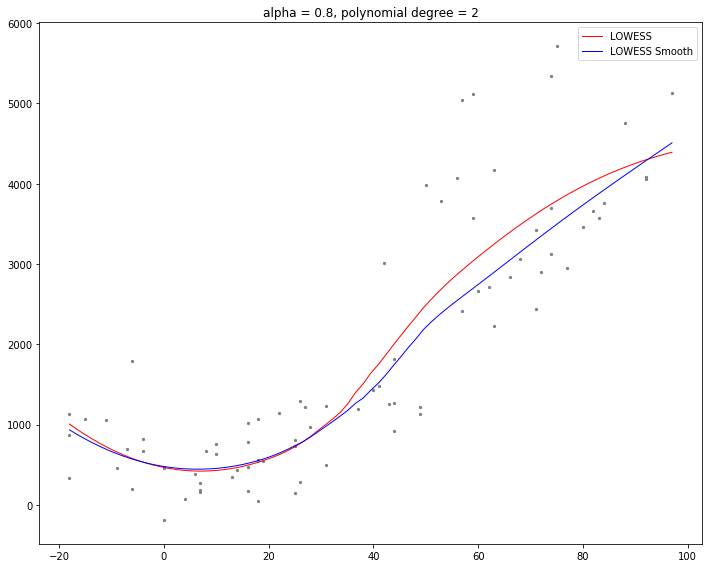

In [9]:
evalDF_1 = runLOWESS("X", "Y", data = df, alpha=0.8, poly_degree=2)
evalDF_2 = runSmoothLOWESS("X", "Y", data = df, alpha=0.8, poly_degree=2)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(df["X"], df["Y"], color="grey", marker="o", s=5, label="_nolegend_")
ax1.plot(evalDF_1['interval'], evalDF_1['estimate'], color='red',  linewidth= 1, label="LOWESS")
ax1.plot(evalDF_2['interval'], evalDF_2['estimate'], color='blue', linewidth= 1, label="LOWESS Smooth")
plt.title('alpha = 0.8, polynomial degree = 2')
plt.legend()
plt.tight_layout()